<a href="https://colab.research.google.com/github/gregoryfdel/DSPS_GFoote/blob/master/blob/main/HW4/Galrotation.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepared by federica b bianco @fedhere for UDel DSPS PHYS 467/667

Written up by gregory foote @gregoryfdel

# Testing the significance of Dark Matter

# Setup

Let's setup the rest of the script

In [156]:
%%capture
!pip install requests tqdm numpy pandas astropy

In [157]:
import os
from typing import List, Tuple


import matplotlib.pyplot as plt
from matplotlib.pyplot import Text
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import astropy as ap
from astropy import units


import requests
from tqdm import tqdm


# Check if using google colab https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Use LaTeX and HTML for outputting text and tables
from IPython.display import Latex, HTML, display

def latex_print(in_string):
    """
    Outputs a string as if it is LaTeX

    :param string: Input Python String
    :return handle: Output handler for the display object 
    """

    in_string = f"\\textnormal{{{in_string}}}" if IN_COLAB else in_string
    return display(Latex(in_string))


def html_table(input_list, table_style="" , cell_decorator=None):
    """
    Outputs an 2D iterable as an html table

    :param input_list: Python Iterable
    :param table_style: CSS which styles the final table
    :param cell_decorator:  Callable which will accept the 
                            cell and it's location and perform
                            some action which will alter the 
                            look of the cell
    
    :return handle: Output handler for the display object
    """

    input_list = np.array(input_list)

    output_html = f"<table style=\"{table_style}\">"
    for cell_row, row in enumerate(input_list):
        output_html += r"<tr>"
        for cell_col, cell in enumerate(row):
            cell_str = str(cell)
            if cell_decorator is not None:
                cell_str = cell_decorator(cell, cell_row, cell_col)
            output_html += f"<td>{cell_str}</td>"
        output_html += r"</tr>"

    output_html += r"</table>"
    return display(HTML(output_html))

%matplotlib inline

## Galatic Rotational Curves

The data comes from [SOFUE 2015](http://www.ioa.s.u-tokyo.ac.jp/~sofue/htdocs/2015m31/2015-pasj-M31MW-DH.pdf)
The data are plotted in Figure 3 and 4 for M31 and the Milky Way respectively, and hosted on [this website](http://www.ioa.s.u-tokyo.ac.jp/~sofue/htdocs/2015m31/)
As described in the paper: 
Long and short bars represent modified standard deviations and errors, respectively

#### Please read the last paragraphs of Section 2.1 of the paper to understand the meaning of these uncertainties:

![figures](figures.png)



In 1970 Vera Rubin published a seminal paper: she measured the rotational speed of HII regions in several galaxies and how it changed as a function of distance to the center of the galaxy. If we believe Newtonian gravity (or GR) we expect that _once all of the mass is included_, i.e. at a radius distance from the center of the galaxy larger than the radius of the galaxy itself, the rotational speed will be proportional to $v\propto\frac{1}/{r}$

### Derive the expected velocity curve from newtonian physics

Derive $v^2\propto\frac{1}{r}$ from Newton's law $F~=~\frac{GMm}{r^2}$. Write each formula and describe each step. You can use latex (you really just need to know ```\frac{}``` and ```^```) and this reference
https://www.physicsclassroom.com/calcpad/circgrav

The final equation will look like this
$v^2 = \frac{G \cdot m(r)}{r}$

$$
\begin{aligned}& F=\dfrac{GMm}{r^{2}}=ma\\ 
& \rightarrow a = \dfrac{GM}{r^{2}} = \dfrac{v^{2}}{r}\\ 
& \rightarrow v^{2}=\dfrac{Gm}{r}\end{aligned}
$$

### M31 rotational curve



![text](text.png)


Get the data from the github repository https://github.com/fedhere/DSPS/tree/master/HW4 : there are 2 files: mw.csv and m31.csv. Start with M31, the Andromeda galaxy, Vera Rubin's original target.

## Propagation of  uncertainties rules

below are the basic rules for propagation of uncertainties - use [this as reference](https://github.com/fedhere/DSPS/blob/master/resources/Managing%20Errors%20and%20Uncertainty.pdf)

$$
\begin{align*}
z = x  \pm y  ~| & ~  &dz = \sqrt{dx^2 + dy^2} 
\\
z = x * y  ~| & ~& dz = |xy|  \sqrt{\left(\frac{dx}{x}\right)^2 + 
                                \left(\frac{dy}{y}\right)^2} \\
z = x / y  ~| & ~& dz = \left|\frac{x}{y}\right| \sqrt{\left(\frac{dx}{x}\right)^2 + 
                                                   \left(\frac{dy}{y}\right)^2} \\
z = x^n ~| & ~& dz = |n| ~ x^{n-1}  dx \\
z = \mathrm{c}x ~| & ~& dz = |\mathrm{c}| ~dx \\
z = f(x, y) ~| & ~& dz = \sqrt{\left(\frac{\partial f}{\partial x}\right)^2 dx^2 +\left(\frac{\partial f}{\partial y}\right)^2 dy^2} \\
\end{align*}
$$


## Data Ingestion

Note that the data contains 2 types of uncertainties: one significantly smaller than the other. The ```dv``` uncertainty is the propagation of the uncertainty in the location of the HII line. The uncertainty called ```err``` if the full error budget:  including _all_ sources of uncertainty and not just the uncertainty in measuring the location of the line. Retain both, you will test your hypothesis with each one to see if it matters which uncertainty you choose

In [158]:
def get_files_from_internet(files_url: List[str]):
    '''Grabs files from the internet using the requests library

    :param files_url: List of file URLs

    :return file_names: The extracted file names of the files which were downloaded
    '''

    file_names = []
    for file_url in files_url:
        filename = file_url.split(r"/")[-1]
        if not os.path.exists(filename):
            response = requests.get(file_url, stream=True)
            response.raise_for_status()
            
            # https://stackoverflow.com/questions/43743438/using-tqdm-to-add-a-progress-bar-when-downloading-files
            total_size = int(response.headers["Content-Length"])
            
            with open(filename, "w") as handle:
                with tqdm(unit='B', unit_divisor=1024, unit_scale=True, miniters=1, desc=filename, total=total_size) as pbar:
                    for block in response.iter_lines(1024, decode_unicode=True):
                        handle.write(block + "\n")
                        pbar.update(len(block))
        file_names.append(filename)
    return file_names

rv_files = get_files_from_internet(
    [
        "https://raw.githubusercontent.com/fedhere/DSPS_FBianco/master/HW4/m31.csv",
        "https://raw.githubusercontent.com/fedhere/DSPS_FBianco/master/HW4/mw.csv"
    ]
)

data_processed = {
    os.path.splitext(fn)[0]: pd.read_csv(fn, skiprows=1, delimiter=',').set_axis(['r', 'v','dv', 'err'], axis=1, inplace=False) for fn in rv_files
}

In [159]:
display(data_processed['m31'].head())
display(data_processed['m31'].describe())

,r,v,dv,err
0,0.100,183.939,0.000,0.000
1,0.120,190.710,10.265,12.191
2,0.144,204.141,22.634,21.808
3,0.173,207.601,4.573,4.200
4,0.207,210.188,3.943,3.258


,r,v,dv,err
count,55.000000,55.000000,55.000000,55.000000
mean,205.853182,226.079255,55.034818,16.165855
std,415.523904,42.799892,49.254792,14.876951
min,0.100000,121.974000,0.000000,0.000000
25%,1.177000,208.894500,11.945500,3.224000
50%,13.737000,229.124000,30.697000,12.065000
75%,161.675000,244.102500,99.980000,23.641000
max,1887.071000,414.942000,147.835000,54.110000


from https://en.wikipedia.org/wiki/Andromeda_Galaxy get the extent of the luminous component of M31 (Andromeda). The distance of the Galaxy multiplied by the angular size will give you this information from basic trigonometry (make sure you convert the units properly, using astropy). Make sure you include the uncertainties! uncertainties in the distance will give you the uncertainty in the size.
 

## Helper Classes

In [160]:
class UncertainQuanitity:

    def __init__(self, value_, uncertainity_ = None, unit_ = None) -> None:
        if isinstance(value_, UncertainQuanitity):
            self.quantity = value_.quantity
            self.uncertainity = value_.uncertainity
        else:
            if isinstance(value_, units.Quantity):
                self.quantity = value_
            else:
                self.quantity = value_ * unit_
            
            if isinstance(uncertainity_, units.Quantity):
                self.uncertainity = uncertainity_
            else:
                self.uncertainity = uncertainity_ * unit_

    @property
    def value(self):
        return (self.quantity.value, self.uncertainity.value)

    @property
    def unit(self):
        return self.quantity.unit
    
    @unit.setter
    def unit(self, new_unit):
        self.quantity = self.quantity.to(new_unit)  
        self.uncertainity = self.uncertainity.to(new_unit)  

    def copy(self):
        return UncertainQuanitity(self)

    def to(self, other_unit, **kwargs):
        new_obj = self.copy()
        new_obj.quantity = new_obj.quantity.to(other_unit, **kwargs)  
        new_obj.uncertainity = new_obj.uncertainity.to(other_unit, **kwargs)  
        new_obj.unit = other_unit
        return new_obj
    
    def contains(self, test_val):
        sqv, suv = self.value
        return sqv - suv < test_val < sqv + suv
    
    def __str__(self):
        return f"{self.quantity.value:.2f} \u00B1 {self.uncertainity.value:.2f} {self.unit}"
    
    def __mul__(self, other):
        if isinstance(other, UncertainQuanitity):
            sqv, suv = self.value
            oqv, ouv = other.value
            
            rv_value = sqv * oqv
            rv_uncertainity = abs(rv_value) * np.sqrt(np.square(suv/sqv) + np.square(ouv/oqv))
            
            rv_unit = self.unit * other.unit
            return UncertainQuanitity(rv_value, rv_uncertainity, rv_unit)
        elif isinstance(other, (float, int)):
            rv_value, rv_uncertainity = self.value
            rv_value *= other
            rv_uncertainity *= other
            return UncertainQuanitity(rv_value, rv_uncertainity, self.unit)
        else:
            raise TypeError("Can't multiply an uncertain quanitity with " + str(type(other)))
    
    def __truediv__(self, other):
        if isinstance(other, UncertainQuanitity):
            sqv, suv = self.value
            oqv, ouv = other.value
            
            rv_value = sqv / oqv
            rv_uncertainity = abs(rv_value) * np.sqrt(np.square(suv/sqv) + np.square(ouv/oqv))
            
            rv_unit = self.unit / other.unit
            return UncertainQuanitity(rv_value, rv_uncertainity, rv_unit)
        elif isinstance(other, (float, int)):
            rv_value, rv_uncertainity = self.value
            rv_value /= other
            rv_uncertainity /= other
            return UncertainQuanitity(rv_value, rv_uncertainity, self.unit)
        else:
            raise TypeError("Can't divide an uncertain quanitity with " + str(type(other)))

class GalaxyInfo:
    def __init__(self, name_, angular_size_=None, distance_=None):
        self.name = name_
        self.angular_size = angular_size_
        self.distance = distance_
    
    @property
    def visible_component(self):
        return (self.distance * self.angular_size.to(units.radian)).to(self.distance.unit, equivalencies=units.dimensionless_angles())


# http://ned.ipac.caltech.edu/cgi-bin/datasearch?search_type=Diam_id&objid=58141&objname=MESSIER%20031&img_stamp=YES&hconst=73.0&omegam=0.27&omegav=0.73&corr_z=1&of=table
# https://ui.adsabs.harvard.edu/abs/2012ApJ...745..156R/abstract

m31_info = GalaxyInfo("m31", UncertainQuanitity(3.175, 0.074, units.deg), UncertainQuanitity(752, 27, units.kpc))
latex_print(f"Angular Size of the visible component of Andromeda: {m31_info.angular_size}")
latex_print(f"Distance to Andromeda: {m31_info.distance}")
latex_print(f"Size of the visible component of Andromeda: {m31_info.visible_component}")
            
        

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Find the first measurement  in your data table that includes all the luminous mass. 

What is the smallest radius in your data where the luminous mass is completely included and what is the veolcity at that radius?

We expect the velocity to decrease as 1/r if all mass is included: the velocity at a radius twice as far as the radius that includes all the mass should be a factor 2 slower, three times as far a factor 3 slower. 

write a function that 

1. finds the smallest radius in the dataset that is at least N times the radius of the visible galaxy, 

2. takes as arguments:
    - the data and 
    - N 
    - the size of the luminous component of the galaxy
 
2. Returns the value of the radius and its uncertainty and the velocity and its uncertainty

In [161]:
class RowInfo:
    def __init__(self, *args) -> None:
        if len(args) == 6:
            rad_, vel_, vel_dv, vel_err, rad_unit, vel_unit = args
            self.rad = rad_ * rad_unit
            self.vel_dv = UncertainQuanitity(vel_, vel_dv, vel_unit)
            self.vel_err = UncertainQuanitity(vel_, vel_err, vel_unit)
        elif isinstance(args[0], RowInfo):
            self.rad = args[0].rad
            self.vel_dv = args[0].vel_dv
            self.vel_err = args[0].vel_err
        else:
            raise ValueError("Bad Initialization for RowInfo!")
    
    def copy(self):
        return RowInfo(self)

def get_radii(gal_info: GalaxyInfo, n: float) -> RowInfo:
    '''Gets the smallest encompassing multiple of the radius and corresponding velocity of a galaxy

    :param gal_info: GalaxyInfo object containing the information about
      the galaxy
    :param n: The multiple to test

    :return tuple: (UncertainQuanitity of the encompassing radius, UncertainQuanitity of the velocity)
    '''
    global data_processed
    v_rad = gal_info.visible_component
    test_rad = v_rad.quantity.value * n
    gal_df = data_processed.get(gal_info.name)
    rv = gal_df.loc[lambda x: x['r'] <= test_rad].iloc[-1].to_list()
    return RowInfo(*rv, units.kpc, units.km/units.s)


## Data Visualization

### Make a plot that shows

---
1. the rotational curve of the galaxy (as a line)

2. each velocity as an errorbar with error equal to err in the same color as the line in 1

3. each velocity as an errorbar with error equal to dv in  the same color but a different line thickness

---

1. the datapoint corresponding to N=1, 2, 3 each in a different color. 

2. add a legend that indicates the meaning of each color (```pl.legend()```)

3. add a text that indicates the velocity and its uncertainty (dv and err) just below the largest errorbar (```pl.text()```)

4. limit the x axis to the "relevant" portion of the data

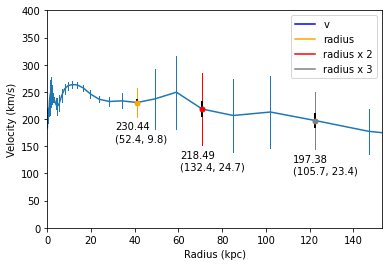

In [162]:
def build_artists(row_info: RowInfo, extras=False, **kwargs):
    r_artists = []
    r_val = row_info.rad.value
    _, v_dv = row_info.vel_dv.value
    v_val, v_err = row_info.vel_err.value
    r_artists.append(Line2D([r_val, r_val], [v_val - v_dv/2, v_val + v_dv/2], linewidth=1.0, **kwargs))
    if extras:
        r_artists.append(Line2D([r_val, r_val], [v_val - v_err/2, v_val + v_err/2], linewidth=2.0, color='black'))
        y_text = v_val - v_dv/2 - 45
        x_text = r_val - 10
        r_artists.append(Text(x_text, y_text, text=f"{v_val:.2f}\n({v_dv:.1f}, {v_err:.1f})"))
        r_artists.append(Line2D([r_val], [v_val], fillstyle="full", marker='o', markersize=5, **kwargs))
    
    return r_artists

def plot_galaxy_radius(gal_info: GalaxyInfo):
    global data_processed
    point_list : pd.DataFrame = data_processed.get(gal_info.name)
    plot_pt_list = point_list.apply(lambda rv:  RowInfo(*rv, units.kpc, units.km/units.s), axis=1)
    fig, ax = plt.subplots()
    ax.plot(point_list['r'], point_list['v'])
    for pt in plot_pt_list:
        for artist in build_artists(pt):
            ax.add_artist(artist)
    
    color_arr = ["orange", "red", "grey"]
    rad_cache = []
    for line_color, n_pt in zip(color_arr, list(range(1, 4))):
        cur_rad = get_radii(gal_info, n_pt)
        rad_cache.append(cur_rad.rad.value)
        for artist in build_artists(cur_rad, extras=True, color=line_color):
            ax.add_artist(artist)
    
    max_x = max(rad_cache) * 1.25
    ax.set(xlim=[0, max_x], ylim=[0, 400], xlabel="Radius (kpc)", ylabel="Velocity (km/s)")
    
    legend_handles = [Line2D([0,0],[0,1], color='blue')]
    legend_handles.extend([Line2D([0,0],[0,1], color=cl) for cl in color_arr])
    ax.legend(legend_handles, ["v", "radius", "radius x 2", "radius x 3"])

plot_galaxy_radius(m31_info)

Write a function that for a given dataset and a given luminous radius and a given N 
  
  1) uses the function above to find the radius at least as large as needed and the velocity at that radius, 
  
  2) states the expected drop in rotational velocities according to Newton's law $v^2\propto 1/r$
  
  3) calculates the ratio of radii and the ratio of velocities at N radii from the center N=1 and N=N (input, e.g. 2, 3 etc) with uncertainties, 
  
  4) and stated whether that ratio is consistent within the uncertainties with Newton's law $v^2 \propto 1/r$
  
Your function should print 

     - the expected ratio based on the radii, 
     - the calculated ratio using ```dv```, and its uncertainty, - 
     - the 2-$\sigma$ upper and lower limits of the calculated ratio
     - whether the expected ratio is within the $2-\sigma$ of the calculated ratio, 
  5) and the same using ```err```  instead of ```dv```

In [163]:
def velocity_ratios(gal_info: GalaxyInfo, n, err='dv'):
      r_1 = get_radii(gal_info, 1)
      r_n = get_radii(gal_info, n)
      
      r_ratio = r_1.rad / r_n.rad
      if err == "dv":
            v_ratio = (r_1.vel_dv*r_1.vel_dv) / (r_n.vel_dv*r_n.vel_dv)
      elif err == "err":
            v_ratio = (r_1.vel_err*r_1.vel_err) / (r_n.vel_err*r_n.vel_err)
      else:
            raise ValueError("Please input `err` or `dv` into err=")

      v2_ratio = v_ratio.copy()
      v2_ratio.uncertainity = v2_ratio.uncertainity * 2
      
      print(f"Expected ratio at a galatic radii of {n} based on $\\frac{{1}}{{r}}$: {r_ratio:.2f}")
      print(f"The calculated $\\frac{{1}}{{v^2}}$ ratio using {err} at a galatic radii of {n}: {v_ratio}")
      print(f"The 2-$\sigma$ $\\frac{{1}}{{v^2}}$ ratio using {err} at a galatic radii of {n}: {v2_ratio}")
      print("This is Expected" if v2_ratio.contains(r_ratio) else "This is not expected")

for mode in ['dv', 'err']:
      for en_rad in range(1, 4):
            print("")
            print("")
            velocity_ratios(m31_info, en_rad, mode)
      



Expected ratio at a galatic radii of 1 based on $\frac{1}{r}$: 1.00
The calculated $\frac{1}{v^2}$ ratio using dv at a galatic radii of 1: 1.00 ± 0.46 
The 2-$\sigma$ $\frac{1}{v^2}$ ratio using dv at a galatic radii of 1: 1.00 ± 0.91 
This is Expected


Expected ratio at a galatic radii of 2 based on $\frac{1}{r}$: 0.58
The calculated $\frac{1}{v^2}$ ratio using dv at a galatic radii of 2: 1.11 ± 1.02 
The 2-$\sigma$ $\frac{1}{v^2}$ ratio using dv at a galatic radii of 2: 1.11 ± 2.04 
This is Expected


Expected ratio at a galatic radii of 3 based on $\frac{1}{r}$: 0.33
The calculated $\frac{1}{v^2}$ ratio using dv at a galatic radii of 3: 1.36 ± 1.12 
The 2-$\sigma$ $\frac{1}{v^2}$ ratio using dv at a galatic radii of 3: 1.36 ± 2.24 
This is Expected


Expected ratio at a galatic radii of 1 based on $\frac{1}{r}$: 1.00
The calculated $\frac{1}{v^2}$ ratio using err at a galatic radii of 1: 1.00 ± 0.09 
The 2-$\sigma$ $\frac{1}{v^2}$ ratio using err at a galatic radii of 1: 1.00 ± 0

### Discussion

As the radius increases, the newtonian relationship between $1/r$ and $v^2$ diverges, this signfies that newtonian circular motion is not the only effect at work on large scales within M31

## Do the same for the Milky Way



Expected ratio at a galatic radii of 1 based on $\frac{1}{r}$: 1.00
The calculated $\frac{1}{v^2}$ ratio using dv at a galatic radii of 1: 1.00 ± 0.46 
The 2-$\sigma$ $\frac{1}{v^2}$ ratio using dv at a galatic radii of 1: 1.00 ± 0.91 
This is Expected


Expected ratio at a galatic radii of 2 based on $\frac{1}{r}$: 0.58
The calculated $\frac{1}{v^2}$ ratio using dv at a galatic radii of 2: 1.11 ± 1.02 
The 2-$\sigma$ $\frac{1}{v^2}$ ratio using dv at a galatic radii of 2: 1.11 ± 2.04 
This is Expected


Expected ratio at a galatic radii of 3 based on $\frac{1}{r}$: 0.33
The calculated $\frac{1}{v^2}$ ratio using dv at a galatic radii of 3: 1.36 ± 1.12 
The 2-$\sigma$ $\frac{1}{v^2}$ ratio using dv at a galatic radii of 3: 1.36 ± 2.24 
This is Expected


Expected ratio at a galatic radii of 1 based on $\frac{1}{r}$: 1.00
The calculated $\frac{1}{v^2}$ ratio using err at a galatic radii of 1: 1.00 ± 0.09 
The 2-$\sigma$ $\frac{1}{v^2}$ ratio using err at a galatic radii of 1: 1.00 ± 0

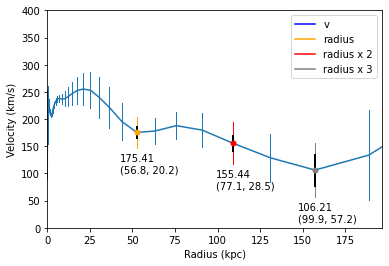

In [164]:
class MilkywayInfo:
    def __init__(self) -> None:
        self.name = "mw"
        self.visible_component = UncertainQuanitity(185, 15, 1000 * units.lyr).to(units.kpc)

milkyway_info = MilkywayInfo()
plot_galaxy_radius(milkyway_info)

for mode in ['dv', 'err']:
      for en_rad in range(1, 4):
            print("")
            print("")
            velocity_ratios(m31_info, en_rad, mode)